In [ ]:
import numpy as np
import heapq
from ortools.linear_solver import pywraplp
import random
from typing import List, Tuple, Dict, Set
import matplotlib.pyplot as plt
import time

class MCFLPD_Solver:
    """
    A solver class for the Maximum Coverage Capacitated Facility Location Problem
    with Range Constrained Drones (MCFLPD), now with visualization capabilities.
    """
    
    def __init__(self,
                 p: int,
                 K: int,
                 U: float,
                 B: float,
                 d: List[float],
                 b: List[List[float]],
                 w: List[float],
                 facility_locations: List[Tuple[float, float]] = None,
                 demand_locations: List[Tuple[float, float]] = None):
        """
        Initialize the MCFLPD solver with problem parameters and optional coordinates for visualization.
        """
        self.p = p
        self.K = K
        self.U = U
        self.B = B
        self.d = d
        self.b = b
        self.w = w
        self.num_demand_points = len(d)
        self.num_facility_locations = len(b[0]) if self.num_demand_points > 0 else 0
        
        # For visualization
        self.facility_locations = facility_locations if facility_locations else self._generate_default_locations(self.num_facility_locations)
        self.demand_locations = demand_locations if demand_locations else self._generate_default_locations(self.num_demand_points)
        
        # Validate coordinate data
        if len(self.facility_locations) != self.num_facility_locations:
            raise ValueError("Number of facility locations must match number of facility indices in b matrix")
        if len(self.demand_locations) != self.num_demand_points:
            raise ValueError("Number of demand locations must match length of demand list d")
    
    def _generate_default_locations(self, n: int) -> List[Tuple[float, float]]:
        """Generate random locations if none are provided."""
        return [(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(n)]
    
    def visualize_solution(self, 
                         open_facilities: List[int], 
                         assignments: Dict[int, List[List[int]]],
                         title: str = "MCFLPD Solution Visualization") -> None:
        """
        Visualize the solution showing facilities, demand points, and drone routes.
        """
        plt.figure(figsize=(12, 8))
        
        # Plot all potential facility locations (gray)
        all_facility_x = [loc[0] for loc in self.facility_locations]
        all_facility_y = [loc[1] for loc in self.facility_locations]
        plt.scatter(all_facility_x, all_facility_y, c='gray', s=100, marker='s', label='Potential Facilities', alpha=0.3)
        
        # Plot open facilities (green)
        open_facility_x = [self.facility_locations[j][0] for j in open_facilities]
        open_facility_y = [self.facility_locations[j][1] for j in open_facilities]
        plt.scatter(open_facility_x, open_facility_y, c='green', s=150, marker='s', label='Open Facilities')
        
        # Plot demand points (blue)
        demand_x = [loc[0] for loc in self.demand_locations]
        demand_y = [loc[1] for loc in self.demand_locations]
        plt.scatter(demand_x, demand_y, c='blue', s=50, label='Demand Points')
        
        # Plot drone routes (colored arrows)
        colors = plt.cm.get_cmap('tab10', len(open_facilities))
        for idx, j in enumerate(open_facilities):
            facility_loc = self.facility_locations[j]
            for drone_path in assignments.get(j, []):
                for i in drone_path:
                    demand_loc = self.demand_locations[i]
                    plt.arrow(
                        facility_loc[0], facility_loc[1],
                        demand_loc[0] - facility_loc[0], demand_loc[1] - facility_loc[1],
                        head_width=1, head_length=1, fc=colors(idx), ec=colors(idx),
                        length_includes_head=True, alpha=0.7
                    )
        
        # Add labels and legend
        plt.title(title)
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend()
        
        # Add facility and demand labels
        for j in range(self.num_facility_locations):
            plt.text(self.facility_locations[j][0], self.facility_locations[j][1], 
                    f'F{j}', ha='center', va='bottom', color='black')
        
        for i in range(self.num_demand_points):
            plt.text(self.demand_locations[i][0], self.demand_locations[i][1], 
                    f'D{i}(d={self.d[i]},w={self.w[i]})', ha='center', va='bottom', 
                    color='blue', fontsize=8)
        
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    def greedy_heuristic(self) -> Tuple[float, List[int], Dict[int, List[List[int]]], float]:
        """
        Implements a greedy heuristic for the MCFLPD.
        Returns:
            Tuple containing:
            - total_demand_served
            - open_facilities
            - assignments
            - execution_time in seconds
        """
        start_time = time.time()
        
        # Original greedy heuristic implementation
        weight_matrix = []
        for i in range(self.num_demand_points):
            for j in range(self.num_facility_locations):
                if self.b[i][j] <= self.B:
                    weight_ratio = self.w[i] / self.b[i][j] if self.b[i][j] > 0 else float('inf')
                    weight_matrix.append((-weight_ratio, i, j))

        heapq.heapify(weight_matrix)

        open_facilities_set = set()
        facility_current_demand = {}
        demand_to_facility_assignment = {}
        facility_remaining_capacity = {}

        while weight_matrix and len(demand_to_facility_assignment) < self.num_demand_points:
            neg_weight_ratio, i, j = heapq.heappop(weight_matrix)
            weight_ratio = -neg_weight_ratio

            if i in demand_to_facility_assignment or weight_ratio <= 0:
                continue

            if j in open_facilities_set:
                if facility_remaining_capacity[j] >= self.d[i]:
                    demand_to_facility_assignment[i] = j
                    facility_current_demand[j] += self.d[i]
                    facility_remaining_capacity[j] -= self.d[i]
            else:
                if len(open_facilities_set) < self.p and self.d[i] <= self.U:
                    open_facilities_set.add(j)
                    demand_to_facility_assignment[i] = j
                    facility_current_demand[j] = self.d[i]
                    facility_remaining_capacity[j] = self.U - self.d[i]
                else:
                    best_j_for_i = None
                    min_battery_consumption = float('inf')
                    for open_j in open_facilities_set:
                        if (self.b[i][open_j] <= self.B and
                                facility_remaining_capacity[open_j] >= self.d[i] and
                                self.b[i][open_j] < min_battery_consumption):
                            best_j_for_i = open_j
                            min_battery_consumption = self.b[i][open_j]

                    if best_j_for_i is not None:
                        demand_to_facility_assignment[i] = best_j_for_i
                        facility_current_demand[best_j_for_i] += self.d[i]
                        facility_remaining_capacity[best_j_for_i] -= self.d[i]

        open_facilities = list(open_facilities_set)

        # Drone allocation
        drones_estimated_needed = {j: 0 for j in open_facilities}
        for j in open_facilities:
            total_battery_for_facility = sum(self.b[i][j] for i, assigned_j in demand_to_facility_assignment.items() if assigned_j == j)
            drones_estimated_needed[j] = int(np.ceil(total_battery_for_facility / self.B))

        drone_actual_allocation = {j: 0 for j in open_facilities}
        remaining_total_drones = self.K

        drone_priority_queue = []
        for j in open_facilities:
            if drones_estimated_needed[j] > 0:
                heapq.heappush(drone_priority_queue, (-drones_estimated_needed[j], j))

        while remaining_total_drones > 0 and drone_priority_queue:
            neg_estimated_drones, j = heapq.heappop(drone_priority_queue)
            estimated_drones = -neg_estimated_drones

            if drone_actual_allocation[j] < estimated_drones:
                drone_actual_allocation[j] += 1
                remaining_total_drones -= 1

                if drone_actual_allocation[j] < estimated_drones:
                    heapq.heappush(drone_priority_queue, (-(estimated_drones - drone_actual_allocation[j]), j))

        assignments = {j: [[] for _ in range(drone_actual_allocation[j])] for j in open_facilities}
        unserved_demands_due_to_drone_capacity = set()

        for j in open_facilities:
            facility_assigned_demands = [i for i, assigned_j in demand_to_facility_assignment.items() if assigned_j == j]
            facility_assigned_demands.sort(key=lambda i: self.b[i][j])

            drone_idx_counter = 0
            for i in facility_assigned_demands:
                assigned_to_drone = False
                for _ in range(drone_actual_allocation[j]):
                    current_drone_idx = drone_idx_counter % drone_actual_allocation[j] if drone_actual_allocation[j] > 0 else -1

                    if current_drone_idx == -1:
                        break

                    current_load_on_drone = sum(self.b[di][j] for di in assignments[j][current_drone_idx])

                    if current_load_on_drone + self.b[i][j] <= self.B:
                        assignments[j][current_drone_idx].append(i)
                        assigned_to_drone = True
                        break
                    
                    drone_idx_counter += 1

                if not assigned_to_drone:
                    unserved_demands_due_to_drone_capacity.add(i)

        total_demand_served = 0.0
        for j_assignments in assignments.values():
            for drone_path in j_assignments:
                for i in drone_path:
                    total_demand_served += self.w[i]

        execution_time = time.time() - start_time
        return total_demand_served, open_facilities, assignments, execution_time

    def three_stage_heuristic(self, r: int = 1, max_iter: int = 100) -> Tuple[float, List[int], Dict[int, List[List[int]]], float]:
        """
        Implements the Three-Stage Heuristic (3SH) for MCFLPD.
        Returns:
            Tuple containing:
            - best_demand_served
            - best_open_facilities
            - best_solution_assignments
            - execution_time in seconds
        """
        start_time = time.time()
        
        best_solution_assignments = None
        best_demand_served = -1.0
        best_open_facilities = []

        if self.num_facility_locations < self.p:
            initial_open_facilities = list(range(self.num_facility_locations))
        else:
            initial_open_facilities = random.sample(range(self.num_facility_locations), self.p)

        current_open_facilities = initial_open_facilities.copy()

        for iteration in range(max_iter):
            demand_to_facility_assignment, current_total_demand_from_allocation = \
                self._solve_allocation_problem(current_open_facilities)

            current_assignments, current_demand_served_by_drones = \
                self._drone_assignment_knapsack(current_open_facilities, demand_to_facility_assignment)

            if current_demand_served_by_drones > best_demand_served:
                best_demand_served = current_demand_served_by_drones
                best_solution_assignments = current_assignments
                best_open_facilities = current_open_facilities.copy()

            if not current_open_facilities or len(current_open_facilities) < r:
                break

            facility_demand_contribution = {j: 0.0 for j in current_open_facilities}
            for i, assigned_j in demand_to_facility_assignment.items():
                if assigned_j in facility_demand_contribution:
                    facility_demand_contribution[assigned_j] += self.w[i]

            sorted_facilities_by_contribution = sorted(current_open_facilities,
                                                       key=lambda j: facility_demand_contribution.get(j, 0.0))
            facilities_to_remove = sorted_facilities_by_contribution[:r]

            remaining_potential_locations = [j for j in range(self.num_facility_locations)
                                             if j not in current_open_facilities]

            if len(remaining_potential_locations) < r:
                break

            new_facilities_to_add = random.sample(remaining_potential_locations, r)

            current_open_facilities = [j for j in current_open_facilities if j not in facilities_to_remove] + new_facilities_to_add

        execution_time = time.time() - start_time
        return best_demand_served, best_open_facilities, best_solution_assignments, execution_time

    def _solve_allocation_problem(self, open_facilities: List[int]) -> Tuple[Dict[int, int], float]:
        """Original implementation unchanged"""
        solver = pywraplp.Solver.CreateSolver('SCIP')
        if not solver:
            print("Error: SCIP solver not available.")
            return {}, 0.0

        x = {}
        for i in range(self.num_demand_points):
            for j in open_facilities:
                if self.b[i][j] <= self.B:
                    x[i, j] = solver.IntVar(0, 1, f'x_{i}_{j}')

        objective = solver.Objective()
        for (i, j), var in x.items():
            objective.SetCoefficient(var, self.w[i])
        objective.SetMaximization()

        for i in range(self.num_demand_points):
            constraint = solver.Constraint(0, 1, f'demand_assignment_limit_{i}')
            for j in open_facilities:
                if (i, j) in x:
                    constraint.SetCoefficient(x[i, j], 1)

        for j in open_facilities:
            constraint = solver.Constraint(0, self.U, f'facility_capacity_{j}')
            for i in range(self.num_demand_points):
                if (i, j) in x:
                    constraint.SetCoefficient(x[i, j], self.d[i])

        status = solver.Solve()

        demand_assignment = {}
        total_weighted_demand_served = 0.0

        if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
            for i in range(self.num_demand_points):
                for j in open_facilities:
                    if (i, j) in x and x[i, j].solution_value() > 0.5:
                        demand_assignment[i] = j
                        total_weighted_demand_served += self.w[i]
                        break
        else:
            print(f"Warning: Allocation problem did not find an optimal or feasible solution. Status: {status}")

        return demand_assignment, total_weighted_demand_served

    def _drone_assignment_knapsack(self,
                                   open_facilities: List[int],
                                   demand_to_facility_assignment: Dict[int, int]) \
                                   -> Tuple[Dict[int, List[List[int]]], float]:
        """Original implementation unchanged"""
        assignments = {j: [] for j in open_facilities}
        total_weighted_demand_served = 0.0
        remaining_total_drones = self.K

        facility_demands_for_knapsack = {j: [] for j in open_facilities}
        for i, j in demand_to_facility_assignment.items():
            facility_demands_for_knapsack[j].append((i, self.b[i][j], self.w[i]))

        while remaining_total_drones > 0:
            knapsack_results_for_iteration = []

            for j in open_facilities:
                if not facility_demands_for_knapsack[j]:
                    continue

                selected_items_for_drone, value_from_drone = \
                    self._solve_knapsack(facility_demands_for_knapsack[j])

                if value_from_drone > 0:
                    knapsack_results_for_iteration.append((value_from_drone, j, selected_items_for_drone))

            if not knapsack_results_for_iteration:
                break

            knapsack_results_for_iteration.sort(key=lambda x: x[0], reverse=True)
            best_value_this_drone, best_j_for_drone, best_selected_items_for_drone = \
                knapsack_results_for_iteration[0]

            assignments[best_j_for_drone].append([i for i, _, _ in best_selected_items_for_drone])
            total_weighted_demand_served += best_value_this_drone
            remaining_total_drones -= 1

            selected_demand_ids = set(i for i, _, _ in best_selected_items_for_drone)
            facility_demands_for_knapsack[best_j_for_drone] = [
                item for item in facility_demands_for_knapsack[best_j_for_drone]
                if item[0] not in selected_demand_ids
            ]

        return assignments, total_weighted_demand_served

    def _solve_knapsack(self, items: List[Tuple[int, float, float]]) -> Tuple[List[Tuple[int, float, float]], float]:
        """Original implementation unchanged"""
        solver = pywraplp.Solver.CreateSolver('SCIP')
        if not solver:
            print("Error: SCIP solver not available for knapsack.")
            return [], 0.0

        x = {}
        for idx, (i, bij, di) in enumerate(items):
            x[idx] = solver.IntVar(0, 1, f'x_item_{i}')

        knapsack_capacity_constraint = solver.Constraint(0, self.B, 'drone_battery_capacity')
        for idx, (i, bij, di) in enumerate(items):
            knapsack_capacity_constraint.SetCoefficient(x[idx], bij)

        objective = solver.Objective()
        for idx, (i, bij, di) in enumerate(items):
            objective.SetCoefficient(x[idx], di)
        objective.SetMaximization()

        status = solver.Solve()

        selected_items = []
        total_profit = 0.0

        if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
            for idx, item in enumerate(items):
                if x[idx].solution_value() > 0.5:
                    selected_items.append(item)
                    total_profit += item[2]
        else:
            print(f"Warning: Knapsack problem did not find an optimal or feasible solution. Status: {status}")

        return selected_items, total_profit


    def compute_r_gathering_cost(self, open_facilities: List[int], r: int) -> float:
        """
        Compute the cost of r-gathering for given open facilities
        """
        # Create facility and customer data structures for r-gathering
        facilities = []
        for j in open_facilities:
            facilities.append((self.facility_locations[j], 1.0))  # Using uniform opening cost
        
        customers = self.demand_locations
        
        # Assign customers to facilities with r-gathering
        assignments = self.assign_customers_r_gathering(facilities, customers, r)
        
        # Calculate total cost
        total_cost = 0
        for j_idx, j in enumerate(open_facilities):
            if assignments.get(j_idx, []):
                total_cost += 1.0  # Facility opening cost
                for i in assignments[j_idx]:
                    total_cost += euclidean_distance(
                        self.facility_locations[j],
                        self.demand_locations[i]
                    )
        
        # Add penalty for not meeting r-gathering
        penalty = 0
        for j_idx in assignments:
            if len(assignments[j_idx]) < r:
                penalty += 1000 * (r - len(assignments[j_idx])) ** 2
        
        return total_cost + penalty

    def assign_customers_r_gathering(self, facilities, customers, r):
        """
        Assign customers to facilities for r-gathering
        """
        n_facilities = len(facilities)
        n_customers = len(customers)
        assignments = defaultdict(list)
        
        # Calculate distance matrix
        distance_matrix = np.zeros((n_customers, n_facilities))
        for cust_idx in range(n_customers):
            for fac_idx in range(n_facilities):
                distance_matrix[cust_idx, fac_idx] = euclidean_distance(
                    customers[cust_idx], 
                    facilities[fac_idx][0]
                )
        
        # Sort customers by their minimum distance to any facility
        customer_order = np.argsort(np.min(distance_matrix, axis=1))
        
        # Assign customers
        for cust_idx in customer_order:
            best_facility = None
            min_cost = float('inf')
            
            for fac_idx in range(n_facilities):
                current_cost = distance_matrix[cust_idx, fac_idx]
                
                # If facility not open yet, add opening cost
                if not assignments[fac_idx]:
                    current_cost += facilities[fac_idx][1]
                
                # Prefer facilities that need more customers to reach r
                if len(assignments[fac_idx]) < r:
                    current_cost *= 0.9  # Slight preference
                    
                if current_cost < min_cost:
                    min_cost = current_cost
                    best_facility = fac_idx
            
            assignments[best_facility].append(cust_idx)
        
        return assignments

    def optimize_r_with_gradient_descent(self, open_facilities: List[int], initial_r: int = 1, learning_rate: float = 0.1, max_iter: int = 50):
        """
        Use gradient descent to find optimal r value for given open facilities
        """
        current_r = initial_r
        best_r = current_r
        best_cost = float('inf')
        
        for iteration in range(max_iter):
            # Compute cost at current r
            current_cost = self.compute_r_gathering_cost(open_facilities, round(current_r))
            
            # Update best solution
            if current_cost < best_cost:
                best_cost = current_cost
                best_r = round(current_r)
            
            # Numerical gradient calculation
            epsilon = 0.5
            cost_plus = self.compute_r_gathering_cost(open_facilities, round(current_r + epsilon))
            cost_minus = self.compute_r_gathering_cost(open_facilities, round(max(1, current_r - epsilon)))
            
            # Compute gradient
            gradient = (cost_plus - cost_minus) / (2 * epsilon)
            
            # Update r (project back to valid range)
            current_r -= learning_rate * gradient
            current_r = max(1, min(current_r, len(self.demand_locations) // len(open_facilities)))
            
            # Early stopping if gradient is small
            if abs(gradient) < 0.1:
                break
        
        return best_r

    def three_stage_heuristic_with_r_optimization(self, max_iter: int = 100) -> Tuple[float, List[int], Dict[int, List[List[int]]], float, int]:
        """
        Enhanced Three-Stage Heuristic with r-gathering optimization
        Returns:
            Tuple containing:
            - best_demand_served
            - best_open_facilities
            - best_solution_assignments
            - execution_time in seconds
            - optimal_r value found
        """
        start_time = time.time()
        
        best_solution_assignments = None
        best_demand_served = -1.0
        best_open_facilities = []
        optimal_r = 1

        if self.num_facility_locations < self.p:
            initial_open_facilities = list(range(self.num_facility_locations))
        else:
            initial_open_facilities = random.sample(range(self.num_facility_locations), self.p)

        current_open_facilities = initial_open_facilities.copy()

        for iteration in range(max_iter):
            # Find optimal r for current facilities using gradient descent
            current_r = self.optimize_r_with_gradient_descent(current_open_facilities)
            
            demand_to_facility_assignment, current_total_demand_from_allocation = \
                self._solve_allocation_problem(current_open_facilities)

            current_assignments, current_demand_served_by_drones = \
                self._drone_assignment_knapsack(current_open_facilities, demand_to_facility_assignment)

            if current_demand_served_by_drones > best_demand_served:
                best_demand_served = current_demand_served_by_drones
                best_solution_assignments = current_assignments
                best_open_facilities = current_open_facilities.copy()
                optimal_r = current_r

            if not current_open_facilities or len(current_open_facilities) < optimal_r:
                break

            facility_demand_contribution = {j: 0.0 for j in current_open_facilities}
            for i, assigned_j in demand_to_facility_assignment.items():
                if assigned_j in facility_demand_contribution:
                    facility_demand_contribution[assigned_j] += self.w[i]

            sorted_facilities_by_contribution = sorted(current_open_facilities,
                                                       key=lambda j: facility_demand_contribution.get(j, 0.0))
            facilities_to_remove = sorted_facilities_by_contribution[:optimal_r]

            remaining_potential_locations = [j for j in range(self.num_facility_locations)
                                             if j not in current_open_facilities]

            if len(remaining_potential_locations) < optimal_r:
                break

            new_facilities_to_add = random.sample(remaining_potential_locations, optimal_r)

            current_open_facilities = [j for j in current_open_facilities if j not in facilities_to_remove] + new_facilities_to_add

        execution_time = time.time() - start_time
        return best_demand_served, best_open_facilities, best_solution_assignments, execution_time, optimal_r

if __name__ == "__main__":
    # Example problem parameters
    p = 65  # Maximum number of facilities to open
    K = 70  # Total number of drones available
    U = 100.0  # Facility capacity
    B = 50.0  # Drone battery capacity

    # Example data (small problem)
    num_demand_points = 100
    num_facility_locations = 70

    # Random data generation for demonstration
    np.random.seed(42)  # For reproducibility
    
    # Generate coordinates for visualization
    facility_locations = [(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(num_facility_locations)]
    demand_locations = [(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(num_demand_points)]
    
    # Calculate distances (for battery consumption)
    def euclidean_distance(a, b):
        return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
    
    # Battery consumption proportional to distance
    b = []
    for i in range(num_demand_points):
        b_row = []
        for j in range(num_facility_locations):
            distance = euclidean_distance(demand_locations[i], facility_locations[j])
            b_row.append(distance * 2)  # Multiply by 2 for round trip
        b.append(b_row)
    
    d = np.random.randint(1, 20, size=num_demand_points).tolist()  # Demands
    w = [float(val) * 1.5 for val in d]  # Weights (1.5x demand for variation)

    # Create solver instance with locations
    solver = MCFLPD_Solver(p, K, U, B, d, b, w, facility_locations, demand_locations)

    print("Running Greedy Heuristic...")
    greedy_demand, greedy_facilities, greedy_assignments, greedy_time = solver.greedy_heuristic()
    print(f"\nGreedy Heuristic Results:")
    print(f"  Total weighted demand served: {greedy_demand:.2f}")
    print(f"  Open facilities: {greedy_facilities}")
    print(f"  Execution time: {greedy_time:.4f} seconds")
    
    solver.visualize_solution(greedy_facilities, greedy_assignments, "Greedy Heuristic Solution")

    print("\n" + "="*50 + "\n")

    print("Running Three-Stage Heuristic...")
    tsh_demand, tsh_facilities, tsh_assignments, tsh_time, optimal_r = solver.three_stage_heuristic_with_r_optimization(max_iter=50)
    print(f"Optimal r value found: {optimal_r}")
    print(f"\nThree-Stage Heuristic Results:")
    print(f"  Total weighted demand served: {tsh_demand:.2f}")
    print(f"  Open facilities: {tsh_facilities}")
    print(f"  Execution time: {tsh_time:.4f} seconds")
    
    solver.visualize_solution(tsh_facilities, tsh_assignments, "Three-Stage Heuristic Solution")

In [5]:
import math
from collections import defaultdict

def euclidean_distance(a, b):
    """Calculate Euclidean distance between two points"""
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

def r_gathering(facilities, customers, r, facility_capacity=None):
    """
    Solve the r-gathering problem for facility location.
    
    Args:
        facilities: List of tuples (location, opening_cost)
        customers: List of customer locations (x, y)
        r: Minimum number of customers per open facility
        facility_capacity: Optional maximum capacity for each facility (default None for unlimited)
    
    Returns:
        tuple: (total_cost, assignments, opened_facilities)
            total_cost: Total cost of the solution
            assignments: Dictionary {facility_index: [customer_indices]}
            opened_facilities: List of opened facility indices
    """
    if len(customers) < r * len(facilities):
        raise ValueError("Not enough customers to satisfy r-gathering constraint")
    
    if facility_capacity is not None and len(customers) > facility_capacity * len(facilities):
        raise ValueError("Not enough facility capacity to serve all customers")
    
    # Step 1: Calculate distance matrix between customers and facilities
    distance_matrix = []
    for customer in customers:
        distances = []
        for facility in facilities:
            dist = euclidean_distance(customer, facility[0])
            distances.append(dist)
        distance_matrix.append(distances)
    
    # Step 2: Sort customers by their minimum distance to any facility
    customer_min_dist = [(i, min(distances)) for i, distances in enumerate(distance_matrix)]
    customer_min_dist.sort(key=lambda x: x[1])
    sorted_customers = [x[0] for x in customer_min_dist]
    
    # Step 3: Initialize data structures
    assignments = defaultdict(list)
    opened_facilities = set()
    total_cost = 0
    
    # Step 4: Assign customers to facilities
    for customer_idx in sorted_customers:
        # Find the best available facility for this customer
        best_facility = None
        min_cost = float('inf')
        
        for facility_idx in range(len(facilities)):
            # Check if facility can take more customers
            if facility_capacity is not None and len(assignments[facility_idx]) >= facility_capacity:
                continue
                
            # Calculate assignment cost
            cost = distance_matrix[customer_idx][facility_idx]
            if facility_idx not in opened_facilities:
                cost += facilities[facility_idx][1]  # Add opening cost if not already open
            
            if cost < min_cost:
                min_cost = cost
                best_facility = facility_idx
        
        # Assign customer to the best facility
        if best_facility not in opened_facilities:
            opened_facilities.add(best_facility)
            total_cost += facilities[best_facility][1]  # Add opening cost
        
        assignments[best_facility].append(customer_idx)
        total_cost += distance_matrix[customer_idx][best_facility]
    
    # Step 5: Ensure r-gathering constraint is satisfied
    for facility_idx in opened_facilities:
        if len(assignments[facility_idx]) < r:
            # Need to assign more customers to this facility
            needed = r - len(assignments[facility_idx])
            
            # Find nearest unassigned customers
            unassigned = []
            for cust_idx in range(len(customers)):
                assigned = any(cust_idx in v for v in assignments.values())
                if not assigned:
                    dist = distance_matrix[cust_idx][facility_idx]
                    unassigned.append((cust_idx, dist))
            
            unassigned.sort(key=lambda x: x[1])
            
            if len(unassigned) < needed:
                raise ValueError("Cannot satisfy r-gathering constraint with current customer distribution")
            
            # Assign the nearest unassigned customers
            for cust_idx, _ in unassigned[:needed]:
                assignments[facility_idx].append(cust_idx)
                total_cost += distance_matrix[cust_idx][facility_idx]
    
    return total_cost, dict(assignments), list(opened_facilities)

# Example usage
if __name__ == "__main__":
    # Define facilities: each is (location, opening_cost)
    facilities = [
        ((0, 0), 10),  # Facility at (0,0) with opening cost 10
        ((5, 5), 15),  # Facility at (5,5) with opening cost 15
        ((10, 10), 20) # Facility at (10,10) with opening cost 20
    ]
    
    # Define customers as list of locations
    customers = [
        (1, 1), (2, 2), (3, 3),  # Near first facility
        (4, 4), (5, 4), (6, 6),  # Near second facility
        (8, 8), (9, 9), (10, 9), # Near third facility
        (1, 2), (2, 1),           # Extra customers
        (5, 6), (6, 5)            # Extra customers
    ]
    
    r =2 # Minimum customers per facility
    
    total_cost, assignments, opened = r_gathering(facilities, customers, r)
    
    print(f"Total cost: {total_cost}")
    print("Opened facilities:", opened)
    print("Assignments:")
    for fac, cust in assignments.items():
        print(f"Facility {fac} at {facilities[fac][0]} serves customers: {cust}")

Total cost: 59.85896836014856
Opened facilities: [1]
Assignments:
Facility 1 at (5, 5) serves customers: [4, 8, 11, 12, 0, 3, 5, 7, 9, 10, 1, 2, 6]


load e:\coding\mcflpd\mcflpd\lib\site-packages\ortools\.libs\zlib1.dll...
load e:\coding\mcflpd\mcflpd\lib\site-packages\ortools\.libs\abseil_dll.dll...
load e:\coding\mcflpd\mcflpd\lib\site-packages\ortools\.libs\utf8_validity.dll...
load e:\coding\mcflpd\mcflpd\lib\site-packages\ortools\.libs\re2.dll...
load e:\coding\mcflpd\mcflpd\lib\site-packages\ortools\.libs\libprotobuf.dll...
load e:\coding\mcflpd\mcflpd\lib\site-packages\ortools\.libs\highs.dll...
load e:\coding\mcflpd\mcflpd\lib\site-packages\ortools\.libs\ortools.dll...
Running Greedy Heuristic...

Greedy Heuristic Results:
  Total weighted demand served: 1341.00
  Open facilities: [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 31, 32, 33, 37, 38, 40, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 63, 64, 65, 67, 68, 69]
  Execution time: 0.0046 seconds


C:\Users\Prateek\AppData\Local\Temp\ipykernel_13908\2920370221.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(open_facilities))


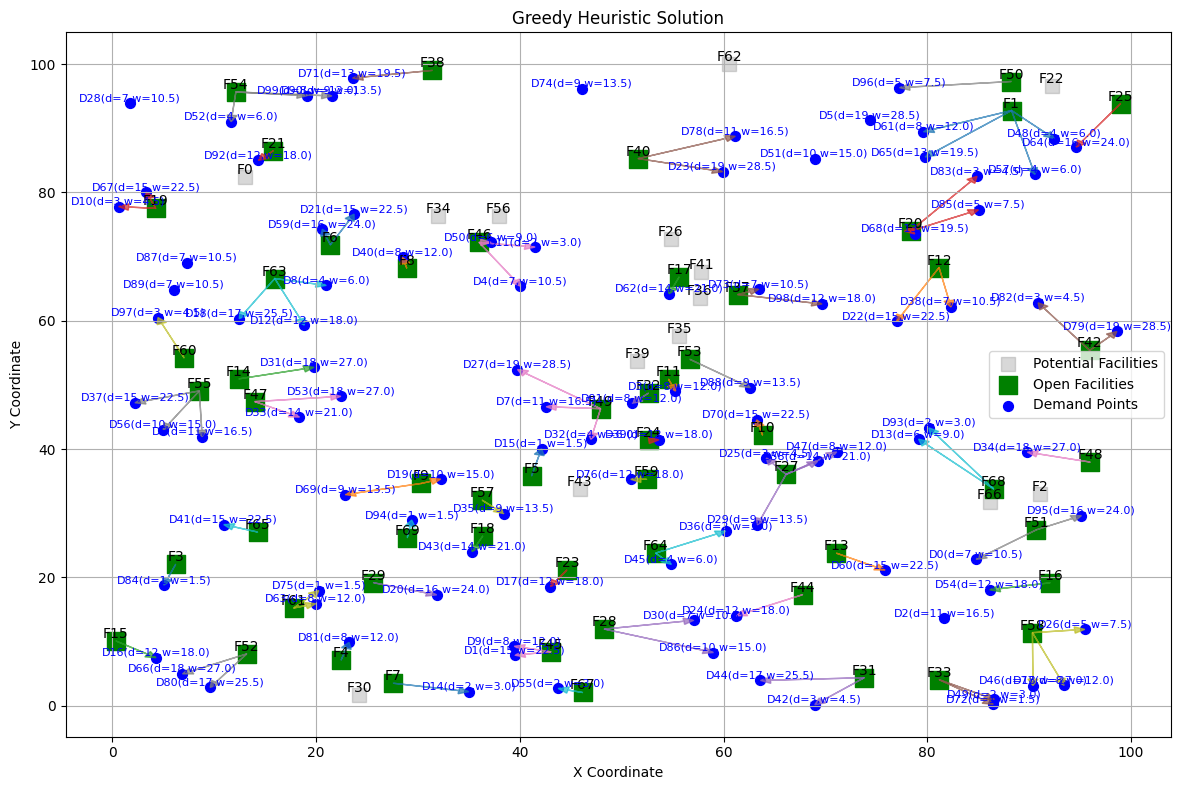



Running Three-Stage Heuristic with R-Gathering Optimization...

Three-Stage Heuristic Results:
  Total weighted demand served: 1420.50
  Open facilities: [12, 34, 58, 60, 0, 59, 3, 17, 28, 46, 69, 56, 7, 40, 36, 30, 42, 22, 43, 49, 2, 53, 6, 25, 63, 47, 65, 55, 16, 66, 38, 15, 68, 18, 5, 21, 9, 11, 51, 44, 62, 23, 1, 52, 24, 29, 14, 26, 32, 19, 48, 67, 27, 8, 13, 41, 20, 64, 33, 39, 50, 10, 31, 54, 4]
  Optimal r value: 1
  Execution time: 581.5307 seconds


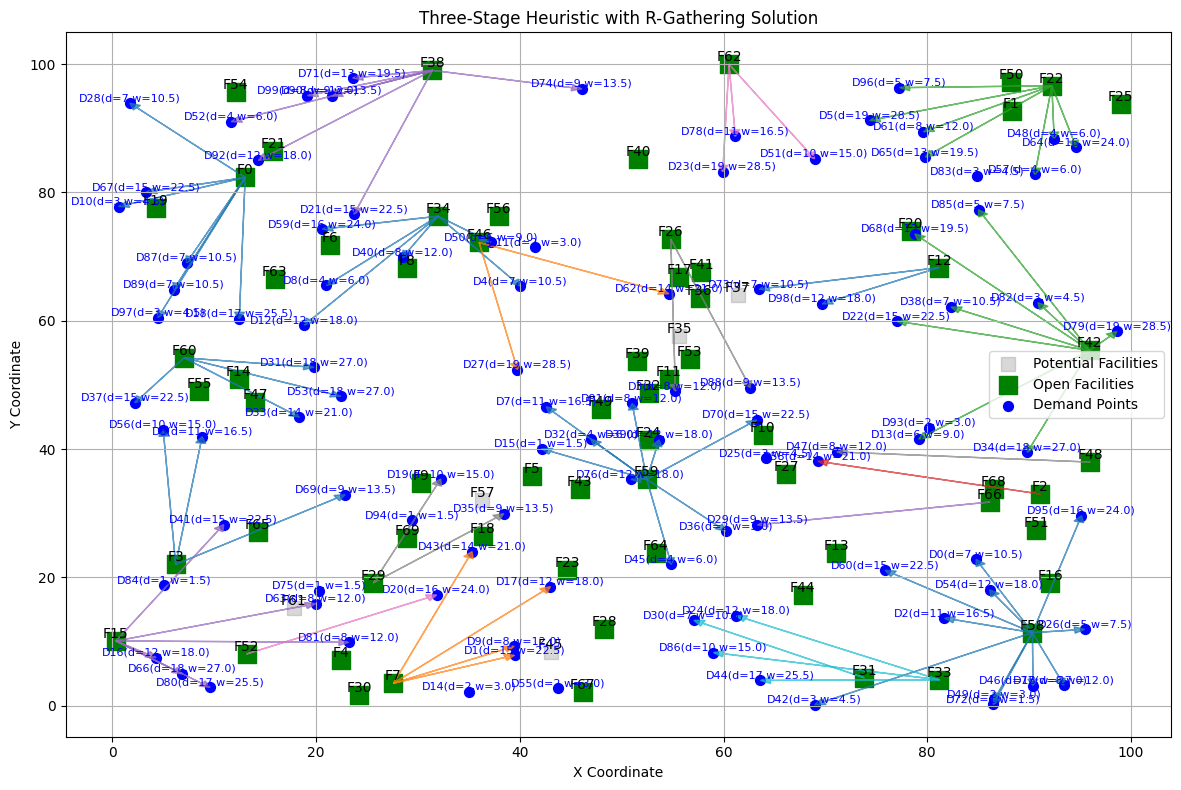

In [1]:
import numpy as np
import heapq
from ortools.linear_solver import pywraplp
import random
from typing import List, Tuple, Dict, Set, DefaultDict
from collections import defaultdict
import matplotlib.pyplot as plt
import time
import math

class MCFLPD_Solver:
    """
    A solver class for the Maximum Coverage Capacitated Facility Location Problem
    with Range Constrained Drones (MCFLPD), now with r-gathering optimization.
    """
    
    def __init__(self,
                 p: int,
                 K: int,
                 U: float,
                 B: float,
                 d: List[float],
                 b: List[List[float]],
                 w: List[float],
                 facility_locations: List[Tuple[float, float]] = None,
                 demand_locations: List[Tuple[float, float]] = None):
        """
        Initialize the MCFLPD solver with problem parameters and optional coordinates for visualization.
        """
        self.p = p
        self.K = K
        self.U = U
        self.B = B
        self.d = d
        self.b = b
        self.w = w
        self.num_demand_points = len(d)
        self.num_facility_locations = len(b[0]) if self.num_demand_points > 0 else 0
        
        # For visualization
        self.facility_locations = facility_locations if facility_locations else self._generate_default_locations(self.num_facility_locations)
        self.demand_locations = demand_locations if demand_locations else self._generate_default_locations(self.num_demand_points)
        
        # Validate coordinate data
        if len(self.facility_locations) != self.num_facility_locations:
            raise ValueError("Number of facility locations must match number of facility indices in b matrix")
        if len(self.demand_locations) != self.num_demand_points:
            raise ValueError("Number of demand locations must match length of demand list d")
    
    def _generate_default_locations(self, n: int) -> List[Tuple[float, float]]:
        """Generate random locations if none are provided."""
        return [(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(n)]
    
    def _euclidean_distance(self, a: Tuple[float, float], b: Tuple[float, float]) -> float:
        """Calculate Euclidean distance between two points"""
        return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
    
    def visualize_solution(self, 
                         open_facilities: List[int], 
                         assignments: Dict[int, List[List[int]]],
                         title: str = "MCFLPD Solution Visualization") -> None:
        """
        Visualize the solution showing facilities, demand points, and drone routes.
        """
        plt.figure(figsize=(12, 8))
        
        # Plot all potential facility locations (gray)
        all_facility_x = [loc[0] for loc in self.facility_locations]
        all_facility_y = [loc[1] for loc in self.facility_locations]
        plt.scatter(all_facility_x, all_facility_y, c='gray', s=100, marker='s', label='Potential Facilities', alpha=0.3)
        
        # Plot open facilities (green)
        open_facility_x = [self.facility_locations[j][0] for j in open_facilities]
        open_facility_y = [self.facility_locations[j][1] for j in open_facilities]
        plt.scatter(open_facility_x, open_facility_y, c='green', s=150, marker='s', label='Open Facilities')
        
        # Plot demand points (blue)
        demand_x = [loc[0] for loc in self.demand_locations]
        demand_y = [loc[1] for loc in self.demand_locations]
        plt.scatter(demand_x, demand_y, c='blue', s=50, label='Demand Points')
        
        # Plot drone routes (colored arrows)
        colors = plt.cm.get_cmap('tab10', len(open_facilities))
        for idx, j in enumerate(open_facilities):
            facility_loc = self.facility_locations[j]
            for drone_path in assignments.get(j, []):
                for i in drone_path:
                    demand_loc = self.demand_locations[i]
                    plt.arrow(
                        facility_loc[0], facility_loc[1],
                        demand_loc[0] - facility_loc[0], demand_loc[1] - facility_loc[1],
                        head_width=1, head_length=1, fc=colors(idx), ec=colors(idx),
                        length_includes_head=True, alpha=0.7
                    )
        
        # Add labels and legend
        plt.title(title)
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend()
        
        # Add facility and demand labels
        for j in range(self.num_facility_locations):
            plt.text(self.facility_locations[j][0], self.facility_locations[j][1], 
                    f'F{j}', ha='center', va='bottom', color='black')
        
        for i in range(self.num_demand_points):
            plt.text(self.demand_locations[i][0], self.demand_locations[i][1], 
                    f'D{i}(d={self.d[i]},w={self.w[i]})', ha='center', va='bottom', 
                    color='blue', fontsize=8)
        
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    def greedy_heuristic(self) -> Tuple[float, List[int], Dict[int, List[List[int]]], float]:
        """
        Implements a greedy heuristic for the MCFLPD.
        Returns:
            Tuple containing:
            - total_demand_served
            - open_facilities
            - assignments
            - execution_time in seconds
        """
        start_time = time.time()
        
        weight_matrix = []
        for i in range(self.num_demand_points):
            for j in range(self.num_facility_locations):
                if self.b[i][j] <= self.B:
                    weight_ratio = self.w[i] / self.b[i][j] if self.b[i][j] > 0 else float('inf')
                    weight_matrix.append((-weight_ratio, i, j))

        heapq.heapify(weight_matrix)

        open_facilities_set = set()
        facility_current_demand = {}
        demand_to_facility_assignment = {}
        facility_remaining_capacity = {}

        while weight_matrix and len(demand_to_facility_assignment) < self.num_demand_points:
            neg_weight_ratio, i, j = heapq.heappop(weight_matrix)
            weight_ratio = -neg_weight_ratio

            if i in demand_to_facility_assignment or weight_ratio <= 0:
                continue

            if j in open_facilities_set:
                if facility_remaining_capacity[j] >= self.d[i]:
                    demand_to_facility_assignment[i] = j
                    facility_current_demand[j] += self.d[i]
                    facility_remaining_capacity[j] -= self.d[i]
            else:
                if len(open_facilities_set) < self.p and self.d[i] <= self.U:
                    open_facilities_set.add(j)
                    demand_to_facility_assignment[i] = j
                    facility_current_demand[j] = self.d[i]
                    facility_remaining_capacity[j] = self.U - self.d[i]
                else:
                    best_j_for_i = None
                    min_battery_consumption = float('inf')
                    for open_j in open_facilities_set:
                        if (self.b[i][open_j] <= self.B and
                                facility_remaining_capacity[open_j] >= self.d[i] and
                                self.b[i][open_j] < min_battery_consumption):
                            best_j_for_i = open_j
                            min_battery_consumption = self.b[i][open_j]

                    if best_j_for_i is not None:
                        demand_to_facility_assignment[i] = best_j_for_i
                        facility_current_demand[best_j_for_i] += self.d[i]
                        facility_remaining_capacity[best_j_for_i] -= self.d[i]

        open_facilities = list(open_facilities_set)

        # Drone allocation
        drones_estimated_needed = {j: 0 for j in open_facilities}
        for j in open_facilities:
            total_battery_for_facility = sum(self.b[i][j] for i, assigned_j in demand_to_facility_assignment.items() if assigned_j == j)
            drones_estimated_needed[j] = int(np.ceil(total_battery_for_facility / self.B))

        drone_actual_allocation = {j: 0 for j in open_facilities}
        remaining_total_drones = self.K

        drone_priority_queue = []
        for j in open_facilities:
            if drones_estimated_needed[j] > 0:
                heapq.heappush(drone_priority_queue, (-drones_estimated_needed[j], j))

        while remaining_total_drones > 0 and drone_priority_queue:
            neg_estimated_drones, j = heapq.heappop(drone_priority_queue)
            estimated_drones = -neg_estimated_drones

            if drone_actual_allocation[j] < estimated_drones:
                drone_actual_allocation[j] += 1
                remaining_total_drones -= 1

                if drone_actual_allocation[j] < estimated_drones:
                    heapq.heappush(drone_priority_queue, (-(estimated_drones - drone_actual_allocation[j]), j))

        assignments = {j: [[] for _ in range(drone_actual_allocation[j])] for j in open_facilities}
        unserved_demands_due_to_drone_capacity = set()

        for j in open_facilities:
            facility_assigned_demands = [i for i, assigned_j in demand_to_facility_assignment.items() if assigned_j == j]
            facility_assigned_demands.sort(key=lambda i: self.b[i][j])

            drone_idx_counter = 0
            for i in facility_assigned_demands:
                assigned_to_drone = False
                for _ in range(drone_actual_allocation[j]):
                    current_drone_idx = drone_idx_counter % drone_actual_allocation[j] if drone_actual_allocation[j] > 0 else -1

                    if current_drone_idx == -1:
                        break

                    current_load_on_drone = sum(self.b[di][j] for di in assignments[j][current_drone_idx])

                    if current_load_on_drone + self.b[i][j] <= self.B:
                        assignments[j][current_drone_idx].append(i)
                        assigned_to_drone = True
                        break
                    
                    drone_idx_counter += 1

                if not assigned_to_drone:
                    unserved_demands_due_to_drone_capacity.add(i)

        total_demand_served = 0.0
        for j_assignments in assignments.values():
            for drone_path in j_assignments:
                for i in drone_path:
                    total_demand_served += self.w[i]

        execution_time = time.time() - start_time
        return total_demand_served, open_facilities, assignments, execution_time

    def compute_r_gathering_cost(self, open_facilities: List[int], r: int) -> float:
        """
        Compute the cost of r-gathering for given open facilities
        """
        facilities = []
        for j in open_facilities:
            facilities.append((self.facility_locations[j], 1.0))  # Using uniform opening cost
        
        customers = self.demand_locations
        assignments = self.assign_customers_r_gathering(facilities, customers, r)
        
        total_cost = 0
        for j_idx, j in enumerate(open_facilities):
            if assignments.get(j_idx, []):
                total_cost += 1.0  # Facility opening cost
                for i in assignments[j_idx]:
                    total_cost += self._euclidean_distance(
                        self.facility_locations[j],
                        self.demand_locations[i]
                    )
        
        penalty = 0
        for j_idx in assignments:
            if len(assignments[j_idx]) < r:
                penalty += 1000 * (r - len(assignments[j_idx])) ** 2
        
        return total_cost + penalty

    def assign_customers_r_gathering(self, 
                                   facilities: List[Tuple[Tuple[float, float], float]], 
                                   customers: List[Tuple[float, float]], 
                                   r: int) -> DefaultDict[int, List[int]]:
        """
        Assign customers to facilities for r-gathering
        """
        n_facilities = len(facilities)
        n_customers = len(customers)
        assignments = defaultdict(list)
        
        distance_matrix = np.zeros((n_customers, n_facilities))
        for cust_idx in range(n_customers):
            for fac_idx in range(n_facilities):
                distance_matrix[cust_idx, fac_idx] = self._euclidean_distance(
                    customers[cust_idx], 
                    facilities[fac_idx][0]
                )
        
        customer_order = np.argsort(np.min(distance_matrix, axis=1))
        
        for cust_idx in customer_order:
            best_facility = None
            min_cost = float('inf')
            
            for fac_idx in range(n_facilities):
                current_cost = distance_matrix[cust_idx, fac_idx]
                
                if not assignments[fac_idx]:
                    current_cost += facilities[fac_idx][1]
                
                if len(assignments[fac_idx]) < r:
                    current_cost *= 0.9
                    
                if current_cost < min_cost:
                    min_cost = current_cost
                    best_facility = fac_idx
            
            assignments[best_facility].append(cust_idx)
        
        return assignments

    def optimize_r_with_gradient_descent(self, 
                                       open_facilities: List[int], 
                                       initial_r: int = 1, 
                                       learning_rate: float = 0.1, 
                                       max_iter: int = 50) -> int:
        """
        Use gradient descent to find optimal r value for given open facilities
        """
        current_r = float(initial_r)
        best_r = round(current_r)
        best_cost = float('inf')
        
        for iteration in range(max_iter):
            current_cost = self.compute_r_gathering_cost(open_facilities, round(current_r))
            
            if current_cost < best_cost:
                best_cost = current_cost
                best_r = round(current_r)
            
            epsilon = 0.5
            cost_plus = self.compute_r_gathering_cost(open_facilities, round(current_r + epsilon))
            cost_minus = self.compute_r_gathering_cost(open_facilities, round(max(1, current_r - epsilon)))
            
            gradient = (cost_plus - cost_minus) / (2 * epsilon)
            current_r -= learning_rate * gradient
            current_r = max(1, min(current_r, len(self.demand_locations) // max(1, len(open_facilities))))
            
            if abs(gradient) < 0.1:
                break
        
        return best_r

    def three_stage_heuristic_with_r_optimization(self, max_iter: int = 100) -> Tuple[float, List[int], Dict[int, List[List[int]]], float, int]:
        """
        Enhanced Three-Stage Heuristic with r-gathering optimization
        Returns:
            Tuple containing:
            - best_demand_served
            - best_open_facilities
            - best_solution_assignments
            - execution_time in seconds
            - optimal_r value found
        """
        start_time = time.time()
        
        best_solution_assignments = None
        best_demand_served = -1.0
        best_open_facilities = []
        optimal_r = 1

        if self.num_facility_locations < self.p:
            initial_open_facilities = list(range(self.num_facility_locations))
        else:
            initial_open_facilities = random.sample(range(self.num_facility_locations), self.p)

        current_open_facilities = initial_open_facilities.copy()

        for iteration in range(max_iter):
            current_r = self.optimize_r_with_gradient_descent(current_open_facilities)
            
            demand_to_facility_assignment, current_total_demand_from_allocation = \
                self._solve_allocation_problem(current_open_facilities)

            current_assignments, current_demand_served_by_drones = \
                self._drone_assignment_knapsack(current_open_facilities, demand_to_facility_assignment)

            if current_demand_served_by_drones > best_demand_served:
                best_demand_served = current_demand_served_by_drones
                best_solution_assignments = current_assignments
                best_open_facilities = current_open_facilities.copy()
                optimal_r = current_r

            if not current_open_facilities or len(current_open_facilities) < optimal_r:
                break

            facility_demand_contribution = {j: 0.0 for j in current_open_facilities}
            for i, assigned_j in demand_to_facility_assignment.items():
                if assigned_j in facility_demand_contribution:
                    facility_demand_contribution[assigned_j] += self.w[i]

            sorted_facilities_by_contribution = sorted(current_open_facilities,
                                                       key=lambda j: facility_demand_contribution.get(j, 0.0))
            facilities_to_remove = sorted_facilities_by_contribution[:optimal_r]

            remaining_potential_locations = [j for j in range(self.num_facility_locations)
                                             if j not in current_open_facilities]

            if len(remaining_potential_locations) < optimal_r:
                break

            new_facilities_to_add = random.sample(remaining_potential_locations, optimal_r)

            current_open_facilities = [j for j in current_open_facilities if j not in facilities_to_remove] + new_facilities_to_add

        execution_time = time.time() - start_time
        return best_demand_served, best_open_facilities, best_solution_assignments, execution_time, optimal_r

    def _solve_allocation_problem(self, open_facilities: List[int]) -> Tuple[Dict[int, int], float]:
        """Original implementation unchanged"""
        solver = pywraplp.Solver.CreateSolver('SCIP')
        if not solver:
            print("Error: SCIP solver not available.")
            return {}, 0.0

        x = {}
        for i in range(self.num_demand_points):
            for j in open_facilities:
                if self.b[i][j] <= self.B:
                    x[i, j] = solver.IntVar(0, 1, f'x_{i}_{j}')

        objective = solver.Objective()
        for (i, j), var in x.items():
            objective.SetCoefficient(var, self.w[i])
        objective.SetMaximization()

        for i in range(self.num_demand_points):
            constraint = solver.Constraint(0, 1, f'demand_assignment_limit_{i}')
            for j in open_facilities:
                if (i, j) in x:
                    constraint.SetCoefficient(x[i, j], 1)

        for j in open_facilities:
            constraint = solver.Constraint(0, self.U, f'facility_capacity_{j}')
            for i in range(self.num_demand_points):
                if (i, j) in x:
                    constraint.SetCoefficient(x[i, j], self.d[i])

        status = solver.Solve()

        demand_assignment = {}
        total_weighted_demand_served = 0.0

        if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
            for i in range(self.num_demand_points):
                for j in open_facilities:
                    if (i, j) in x and x[i, j].solution_value() > 0.5:
                        demand_assignment[i] = j
                        total_weighted_demand_served += self.w[i]
                        break
        else:
            print(f"Warning: Allocation problem did not find an optimal or feasible solution. Status: {status}")

        return demand_assignment, total_weighted_demand_served

    def _drone_assignment_knapsack(self,
                                   open_facilities: List[int],
                                   demand_to_facility_assignment: Dict[int, int]) \
                                   -> Tuple[Dict[int, List[List[int]]], float]:
        """Original implementation unchanged"""
        assignments = {j: [] for j in open_facilities}
        total_weighted_demand_served = 0.0
        remaining_total_drones = self.K

        facility_demands_for_knapsack = {j: [] for j in open_facilities}
        for i, j in demand_to_facility_assignment.items():
            facility_demands_for_knapsack[j].append((i, self.b[i][j], self.w[i]))

        while remaining_total_drones > 0:
            knapsack_results_for_iteration = []

            for j in open_facilities:
                if not facility_demands_for_knapsack[j]:
                    continue

                selected_items_for_drone, value_from_drone = \
                    self._solve_knapsack(facility_demands_for_knapsack[j])

                if value_from_drone > 0:
                    knapsack_results_for_iteration.append((value_from_drone, j, selected_items_for_drone))

            if not knapsack_results_for_iteration:
                break

            knapsack_results_for_iteration.sort(key=lambda x: x[0], reverse=True)
            best_value_this_drone, best_j_for_drone, best_selected_items_for_drone = \
                knapsack_results_for_iteration[0]

            assignments[best_j_for_drone].append([i for i, _, _ in best_selected_items_for_drone])
            total_weighted_demand_served += best_value_this_drone
            remaining_total_drones -= 1

            selected_demand_ids = set(i for i, _, _ in best_selected_items_for_drone)
            facility_demands_for_knapsack[best_j_for_drone] = [
                item for item in facility_demands_for_knapsack[best_j_for_drone]
                if item[0] not in selected_demand_ids
            ]

        return assignments, total_weighted_demand_served

    def _solve_knapsack(self, items: List[Tuple[int, float, float]]) -> Tuple[List[Tuple[int, float, float]], float]:
        """Original implementation unchanged"""
        solver = pywraplp.Solver.CreateSolver('SCIP')
        if not solver:
            print("Error: SCIP solver not available for knapsack.")
            return [], 0.0

        x = {}
        for idx, (i, bij, di) in enumerate(items):
            x[idx] = solver.IntVar(0, 1, f'x_item_{i}')

        knapsack_capacity_constraint = solver.Constraint(0, self.B, 'drone_battery_capacity')
        for idx, (i, bij, di) in enumerate(items):
            knapsack_capacity_constraint.SetCoefficient(x[idx], bij)

        objective = solver.Objective()
        for idx, (i, bij, di) in enumerate(items):
            objective.SetCoefficient(x[idx], di)
        objective.SetMaximization()

        status = solver.Solve()

        selected_items = []
        total_profit = 0.0

        if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
            for idx, item in enumerate(items):
                if x[idx].solution_value() > 0.5:
                    selected_items.append(item)
                    total_profit += item[2]
        else:
            print(f"Warning: Knapsack problem did not find an optimal or feasible solution. Status: {status}")

        return selected_items, total_profit


if __name__ == "__main__":
    # Example problem parameters
    p = 65  # Maximum number of facilities to open
    K = 70  # Total number of drones available
    U = 100.0  # Facility capacity
    B = 50.0  # Drone battery capacity

    # Example data (small problem)
    num_demand_points = 100
    num_facility_locations = 70

    # Random data generation for demonstration
    np.random.seed(42)  # For reproducibility
    
    # Generate coordinates for visualization
    facility_locations = [(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(num_facility_locations)]
    demand_locations = [(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(num_demand_points)]
    
    # Calculate distances (for battery consumption)
    def euclidean_distance(a, b):
        return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
    
    # Battery consumption proportional to distance
    b = []
    for i in range(num_demand_points):
        b_row = []
        for j in range(num_facility_locations):
            distance = euclidean_distance(demand_locations[i], facility_locations[j])
            b_row.append(distance * 2)  # Multiply by 2 for round trip
        b.append(b_row)
    
    d = np.random.randint(1, 20, size=num_demand_points).tolist()  # Demands
    w = [float(val) * 1.5 for val in d]  # Weights (1.5x demand for variation)

    # Create solver instance with locations
    solver = MCFLPD_Solver(p, K, U, B, d, b, w, facility_locations, demand_locations)

    print("Running Greedy Heuristic...")
    greedy_demand, greedy_facilities, greedy_assignments, greedy_time = solver.greedy_heuristic()
    print(f"\nGreedy Heuristic Results:")
    print(f"  Total weighted demand served: {greedy_demand:.2f}")
    print(f"  Open facilities: {greedy_facilities}")
    print(f"  Execution time: {greedy_time:.4f} seconds")
    
    solver.visualize_solution(greedy_facilities, greedy_assignments, "Greedy Heuristic Solution")

    print("\n" + "="*50 + "\n")

    print("Running Three-Stage Heuristic with R-Gathering Optimization...")
    tsh_demand, tsh_facilities, tsh_assignments, tsh_time, optimal_r = solver.three_stage_heuristic_with_r_optimization(max_iter=50)
    print(f"\nThree-Stage Heuristic Results:")
    print(f"  Total weighted demand served: {tsh_demand:.2f}")
    print(f"  Open facilities: {tsh_facilities}")
    print(f"  Optimal r value: {optimal_r}")
    print(f"  Execution time: {tsh_time:.4f} seconds")
    
    solver.visualize_solution(tsh_facilities, tsh_assignments, "Three-Stage Heuristic with R-Gathering Solution")

Running Greedy Heuristic...

Greedy Heuristic Results:
  Total weighted demand served: 1396.50
  Open facilities: [0, 1, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 28, 29, 30, 32, 33, 34, 35, 36, 37, 39, 41, 42, 43, 45, 46, 47, 48, 49, 51, 53, 54, 55, 57, 58, 60, 61, 64, 65, 66, 67, 68, 69]
  Execution time: 0.0020 seconds


C:\Users\Prateek\AppData\Local\Temp\ipykernel_13908\141607564.py:123: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(open_facilities))


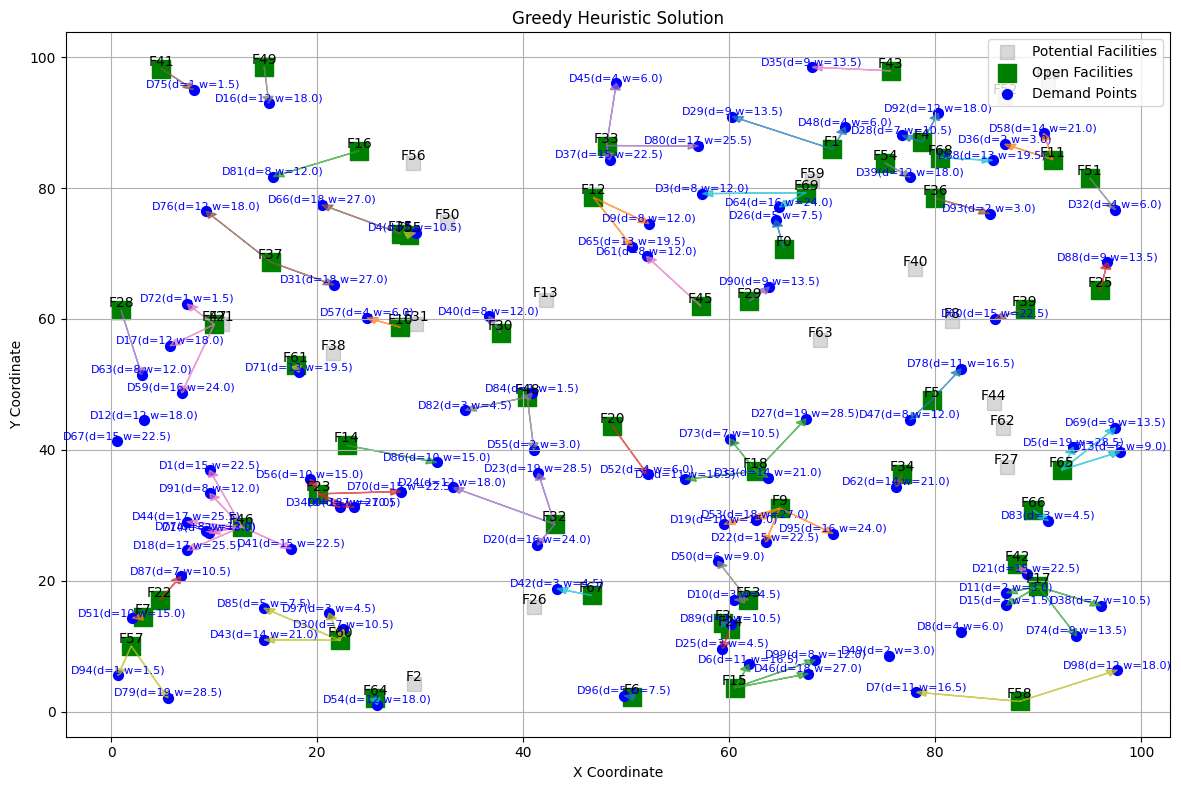



Running Three-Stage Heuristic with R-Gathering Optimization...

Three-Stage Heuristic Results:
  Total weighted demand served: 1419.00
  Open facilities: [41, 58, 57, 19, 20, 33, 21, 62, 6, 23, 40, 64, 16, 42, 9, 13, 1, 25, 29, 26, 51, 10, 53, 50, 43, 32, 34, 36, 37, 15, 49, 28, 61, 60, 48, 63, 46, 8, 4, 0, 65, 5, 12, 14, 22, 39, 69, 66, 30, 18, 67, 56, 27, 35, 54, 52, 24, 45, 11, 2, 38, 44, 17, 7, 68]
  Optimal r value: 1
  Execution time: 871.9132 seconds


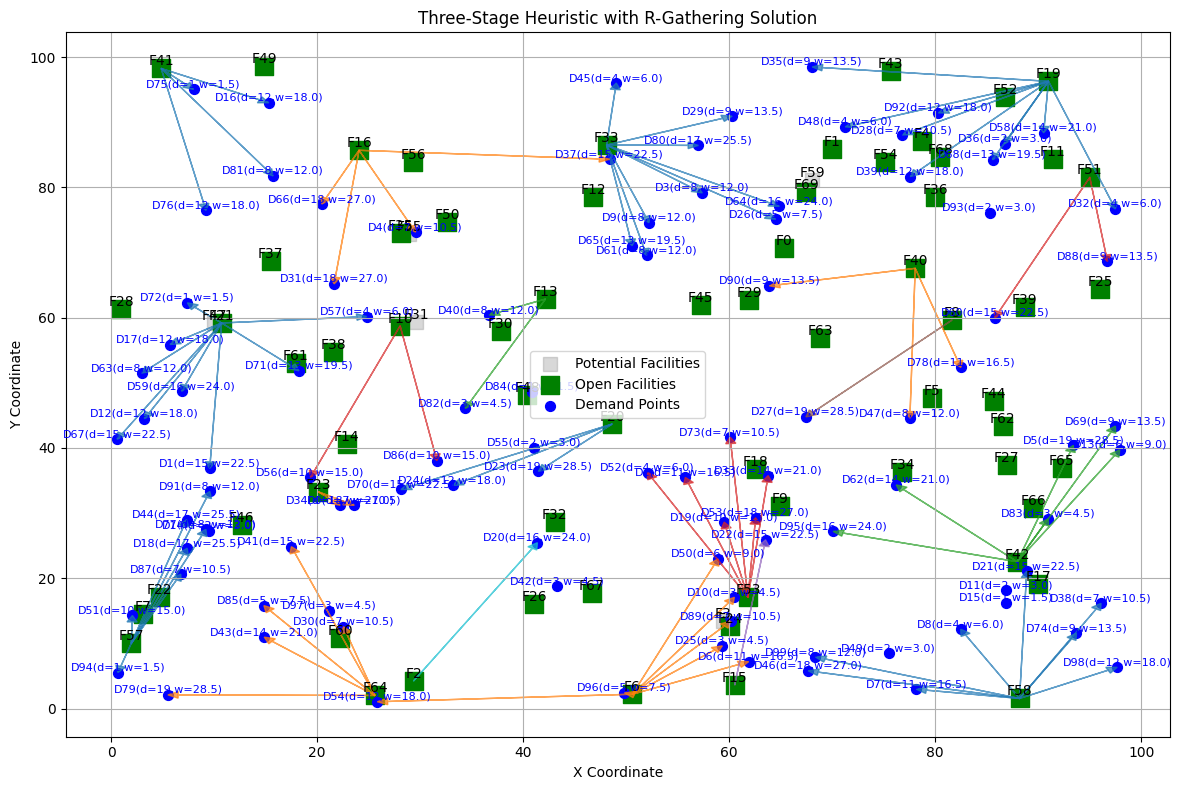

In [ ]:
import numpy as np
import heapq
from ortools.linear_solver import pywraplp
import random
from typing import List, Tuple, Dict, Set, DefaultDict
from collections import defaultdict
import matplotlib.pyplot as plt
import time
import math

class MCFLPD_Solver:
    """
    A solver class for the Maximum Coverage Capacitated Facility Location Problem
    with Range Constrained Drones (MCFLPD), now with r-gathering optimization.
    """
    
    def __init__(self,
                 p: int,
                 K: int,
                 U: float,
                 B: float,
                 d: List[float],
                 b: List[List[float]],
                 w: List[float],
                 facility_locations: List[Tuple[float, float]] = None,
                 demand_locations: List[Tuple[float, float]] = None):
        """
        Initialize the MCFLPD solver with problem parameters and optional coordinates for visualization.
        """
        self.p = p
        self.K = K
        self.U = U
        self.B = B
        self.d = d
        self.b = b
        self.w = w
        self.num_demand_points = len(d)
        self.num_facility_locations = len(b[0]) if self.num_demand_points > 0 else 0
        
        # For visualization
        self.facility_locations = facility_locations if facility_locations else self._generate_default_locations(self.num_facility_locations)
        self.demand_locations = demand_locations if demand_locations else self._generate_default_locations(self.num_demand_points)
        
        # Validate coordinate data
        if len(self.facility_locations) != self.num_facility_locations:
            raise ValueError("Number of facility locations must match number of facility indices in b matrix")
        if len(self.demand_locations) != self.num_demand_points:
            raise ValueError("Number of demand locations must match length of demand list d")
    
    def _generate_default_locations(self, n: int) -> List[Tuple[float, float]]:
        """Generate random locations if none are provided."""
        return [(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(n)]
    
    def _euclidean_distance(self, a: Tuple[float, float], b: Tuple[float, float]) -> float:
        """Calculate Euclidean distance between two points"""
        return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
    
    def _p_dispersion_selection(self, points: List[Tuple[float, float]], p: int) -> List[int]:
        """Select p facilities using p-dispersion (maximin) criterion"""
        if p >= len(points):
            return list(range(len(points)))
        
        # Start with the two farthest points
        max_dist = -1
        selected_indices = []
        
        # Find the pair with maximum distance
        for i in range(len(points)):
            for j in range(i+1, len(points)):
                dist = self._euclidean_distance(points[i], points[j])
                if dist > max_dist:
                    max_dist = dist
                    idx1, idx2 = i, j
        
        selected_indices = [idx1, idx2]
        
        # Greedily add points that maximize the minimum distance
        while len(selected_indices) < p:
            max_min_dist = -1
            best_idx = None
            
            for candidate_idx in range(len(points)):
                if candidate_idx in selected_indices:
                    continue
                    
                # Calculate minimum distance from candidate to selected points
                min_dist = min(self._euclidean_distance(points[candidate_idx], points[s]) 
                              for s in selected_indices)
                
                if min_dist > max_min_dist:
                    max_min_dist = min_dist
                    best_idx = candidate_idx
            
            selected_indices.append(best_idx)
        
        return selected_indices
    
    def visualize_solution(self, 
                         open_facilities: List[int], 
                         assignments: Dict[int, List[List[int]]],
                         title: str = "MCFLPD Solution Visualization") -> None:
        """
        Visualize the solution showing facilities, demand points, and drone routes.
        """
        plt.figure(figsize=(12, 8))
        
        # Plot all potential facility locations (gray)
        all_facility_x = [loc[0] for loc in self.facility_locations]
        all_facility_y = [loc[1] for loc in self.facility_locations]
        plt.scatter(all_facility_x, all_facility_y, c='gray', s=100, marker='s', label='Potential Facilities', alpha=0.3)
        
        # Plot open facilities (green)
        open_facility_x = [self.facility_locations[j][0] for j in open_facilities]
        open_facility_y = [self.facility_locations[j][1] for j in open_facilities]
        plt.scatter(open_facility_x, open_facility_y, c='green', s=150, marker='s', label='Open Facilities')
        
        # Plot demand points (blue)
        demand_x = [loc[0] for loc in self.demand_locations]
        demand_y = [loc[1] for loc in self.demand_locations]
        plt.scatter(demand_x, demand_y, c='blue', s=50, label='Demand Points')
        
        # Plot drone routes (colored arrows)
        colors = plt.cm.get_cmap('tab10', len(open_facilities))
        for idx, j in enumerate(open_facilities):
            facility_loc = self.facility_locations[j]
            for drone_path in assignments.get(j, []):
                for i in drone_path:
                    demand_loc = self.demand_locations[i]
                    plt.arrow(
                        facility_loc[0], facility_loc[1],
                        demand_loc[0] - facility_loc[0], demand_loc[1] - facility_loc[1],
                        head_width=1, head_length=1, fc=colors(idx), ec=colors(idx),
                        length_includes_head=True, alpha=0.7
                    )
        
        # Add labels and legend
        plt.title(title)
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend()
        
        # Add facility and demand labels
        for j in range(self.num_facility_locations):
            plt.text(self.facility_locations[j][0], self.facility_locations[j][1], 
                    f'F{j}', ha='center', va='bottom', color='black')
        
        for i in range(self.num_demand_points):
            plt.text(self.demand_locations[i][0], self.demand_locations[i][1], 
                    f'D{i}(d={self.d[i]},w={self.w[i]})', ha='center', va='bottom', 
                    color='blue', fontsize=8)
        
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    def greedy_heuristic(self) -> Tuple[float, List[int], Dict[int, List[List[int]]], float]:
        """
        Implements a greedy heuristic for the MCFLPD.
        Returns:
            Tuple containing:
            - total_demand_served
            - open_facilities
            - assignments
            - execution_time in seconds
        """
        start_time = time.time()
        
        weight_matrix = []
        for i in range(self.num_demand_points):
            for j in range(self.num_facility_locations):
                if self.b[i][j] <= self.B:
                    weight_ratio = self.w[i] / self.b[i][j] if self.b[i][j] > 0 else float('inf')
                    weight_matrix.append((-weight_ratio, i, j))

        heapq.heapify(weight_matrix)

        open_facilities_set = set()
        facility_current_demand = {}
        demand_to_facility_assignment = {}
        facility_remaining_capacity = {}

        while weight_matrix and len(demand_to_facility_assignment) < self.num_demand_points:
            neg_weight_ratio, i, j = heapq.heappop(weight_matrix)
            weight_ratio = -neg_weight_ratio

            if i in demand_to_facility_assignment or weight_ratio <= 0:
                continue

            if j in open_facilities_set:
                if facility_remaining_capacity[j] >= self.d[i]:
                    demand_to_facility_assignment[i] = j
                    facility_current_demand[j] += self.d[i]
                    facility_remaining_capacity[j] -= self.d[i]
            else:
                if len(open_facilities_set) < self.p and self.d[i] <= self.U:
                    open_facilities_set.add(j)
                    demand_to_facility_assignment[i] = j
                    facility_current_demand[j] = self.d[i]
                    facility_remaining_capacity[j] = self.U - self.d[i]
                else:
                    best_j_for_i = None
                    min_battery_consumption = float('inf')
                    for open_j in open_facilities_set:
                        if (self.b[i][open_j] <= self.B and
                                facility_remaining_capacity[open_j] >= self.d[i] and
                                self.b[i][open_j] < min_battery_consumption):
                            best_j_for_i = open_j
                            min_battery_consumption = self.b[i][open_j]

                    if best_j_for_i is not None:
                        demand_to_facility_assignment[i] = best_j_for_i
                        facility_current_demand[best_j_for_i] += self.d[i]
                        facility_remaining_capacity[best_j_for_i] -= self.d[i]

        open_facilities = list(open_facilities_set)

        # Drone allocation
        drones_estimated_needed = {j: 0 for j in open_facilities}
        for j in open_facilities:
            total_battery_for_facility = sum(self.b[i][j] for i, assigned_j in demand_to_facility_assignment.items() if assigned_j == j)
            drones_estimated_needed[j] = int(np.ceil(total_battery_for_facility / self.B))

        drone_actual_allocation = {j: 0 for j in open_facilities}
        remaining_total_drones = self.K

        drone_priority_queue = []
        for j in open_facilities:
            if drones_estimated_needed[j] > 0:
                heapq.heappush(drone_priority_queue, (-drones_estimated_needed[j], j))

        while remaining_total_drones > 0 and drone_priority_queue:
            neg_estimated_drones, j = heapq.heappop(drone_priority_queue)
            estimated_drones = -neg_estimated_drones

            if drone_actual_allocation[j] < estimated_drones:
                drone_actual_allocation[j] += 1
                remaining_total_drones -= 1

                if drone_actual_allocation[j] < estimated_drones:
                    heapq.heappush(drone_priority_queue, (-(estimated_drones - drone_actual_allocation[j]), j))

        assignments = {j: [[] for _ in range(drone_actual_allocation[j])] for j in open_facilities}
        unserved_demands_due_to_drone_capacity = set()

        for j in open_facilities:
            facility_assigned_demands = [i for i, assigned_j in demand_to_facility_assignment.items() if assigned_j == j]
            facility_assigned_demands.sort(key=lambda i: self.b[i][j])

            drone_idx_counter = 0
            for i in facility_assigned_demands:
                assigned_to_drone = False
                for _ in range(drone_actual_allocation[j]):
                    current_drone_idx = drone_idx_counter % drone_actual_allocation[j] if drone_actual_allocation[j] > 0 else -1

                    if current_drone_idx == -1:
                        break

                    current_load_on_drone = sum(self.b[di][j] for di in assignments[j][current_drone_idx])

                    if current_load_on_drone + self.b[i][j] <= self.B:
                        assignments[j][current_drone_idx].append(i)
                        assigned_to_drone = True
                        break
                    
                    drone_idx_counter += 1

                if not assigned_to_drone:
                    unserved_demands_due_to_drone_capacity.add(i)

        total_demand_served = 0.0
        for j_assignments in assignments.values():
            for drone_path in j_assignments:
                for i in drone_path:
                    total_demand_served += self.w[i]

        execution_time = time.time() - start_time
        return total_demand_served, open_facilities, assignments, execution_time

    def compute_r_gathering_cost(self, open_facilities: List[int], r: int) -> float:
        """
        Compute the cost of r-gathering for given open facilities
        """
        facilities = []
        for j in open_facilities:
            facilities.append((self.facility_locations[j], 1.0))  # Using uniform opening cost
        
        customers = self.demand_locations
        assignments = self.assign_customers_r_gathering(facilities, customers, r)
        
        total_cost = 0
        for j_idx, j in enumerate(open_facilities):
            if assignments.get(j_idx, []):
                total_cost += 1.0  # Facility opening cost
                for i in assignments[j_idx]:
                    total_cost += self._euclidean_distance(
                        self.facility_locations[j],
                        self.demand_locations[i]
                    )
        
        penalty = 0
        for j_idx in assignments:
            if len(assignments[j_idx]) < r:
                penalty += 1000 * (r - len(assignments[j_idx])) ** 2
        
        return total_cost + penalty

    def assign_customers_r_gathering(self, 
                                   facilities: List[Tuple[Tuple[float, float], float]], 
                                   customers: List[Tuple[float, float]], 
                                   r: int) -> DefaultDict[int, List[int]]:
        """
        Assign customers to facilities for r-gathering
        """
        n_facilities = len(facilities)
        n_customers = len(customers)
        assignments = defaultdict(list)
        
        distance_matrix = np.zeros((n_customers, n_facilities))
        for cust_idx in range(n_customers):
            for fac_idx in range(n_facilities):
                distance_matrix[cust_idx, fac_idx] = self._euclidean_distance(
                    customers[cust_idx], 
                    facilities[fac_idx][0]
                )
        
        customer_order = np.argsort(np.min(distance_matrix, axis=1))
        
        for cust_idx in customer_order:
            best_facility = None
            min_cost = float('inf')
            
            for fac_idx in range(n_facilities):
                current_cost = distance_matrix[cust_idx, fac_idx]
                
                if not assignments[fac_idx]:
                    current_cost += facilities[fac_idx][1]
                
                if len(assignments[fac_idx]) < r:
                    current_cost *= 0.9
                    
                if current_cost < min_cost:
                    min_cost = current_cost
                    best_facility = fac_idx
            
            assignments[best_facility].append(cust_idx)
        
        return assignments

    def optimize_r_with_gradient_descent(self, 
                                       open_facilities: List[int], 
                                       initial_r: int = 1, 
                                       learning_rate: float = 0.1, 
                                       max_iter: int = 50) -> int:
        """
        Use gradient descent to find optimal r value for given open facilities
        """
        current_r = float(initial_r)
        best_r = round(current_r)
        best_cost = float('inf')
        
        for iteration in range(max_iter):
            current_cost = self.compute_r_gathering_cost(open_facilities, round(current_r))
            
            if current_cost < best_cost:
                best_cost = current_cost
                best_r = round(current_r)
            
            epsilon = 0.5
            cost_plus = self.compute_r_gathering_cost(open_facilities, round(current_r + epsilon))
            cost_minus = self.compute_r_gathering_cost(open_facilities, round(max(1, current_r - epsilon)))
            
            gradient = (cost_plus - cost_minus) / (2 * epsilon)
            current_r -= learning_rate * gradient
            current_r = max(1, min(current_r, len(self.demand_locations) // max(1, len(open_facilities))))
            
            if abs(gradient) < 0.1:
                break
        
        return best_r

    def three_stage_heuristic_with_r_optimization(self, max_iter: int = 100) -> Tuple[float, List[int], Dict[int, List[List[int]]], float, int]:
        """
        Enhanced Three-Stage Heuristic with p-dispersion in first stage and r-gathering optimization
        Returns:
            Tuple containing:
            - best_demand_served
            - best_open_facilities
            - best_solution_assignments
            - execution_time in seconds
            - optimal_r value found
        """
        start_time = time.time()
        
        best_solution_assignments = None
        best_demand_served = -1.0
        best_open_facilities = []
        optimal_r = 1

        # Stage 1: Facility selection using p-dispersion
        if self.num_facility_locations < self.p:
            initial_open_facilities = list(range(self.num_facility_locations))
        else:
            initial_open_facilities = self._p_dispersion_selection(self.facility_locations, self.p)

        current_open_facilities = initial_open_facilities.copy()

        for iteration in range(max_iter):
            # Stage 2: Optimize r-gathering
            current_r = self.optimize_r_with_gradient_descent(current_open_facilities)
            
            # Solve allocation problem with current facilities
            demand_to_facility_assignment, current_total_demand_from_allocation = \
                self._solve_allocation_problem(current_open_facilities)

            # Stage 3: Drone assignment
            current_assignments, current_demand_served_by_drones = \
                self._drone_assignment_knapsack(current_open_facilities, demand_to_facility_assignment)

            if current_demand_served_by_drones > best_demand_served:
                best_demand_served = current_demand_served_by_drones
                best_solution_assignments = current_assignments
                best_open_facilities = current_open_facilities.copy()
                optimal_r = current_r

            if not current_open_facilities or len(current_open_facilities) < optimal_r:
                break

            # Facility improvement based on r-gathering
            facility_demand_contribution = {j: 0.0 for j in current_open_facilities}
            for i, assigned_j in demand_to_facility_assignment.items():
                if assigned_j in facility_demand_contribution:
                    facility_demand_contribution[assigned_j] += self.w[i]

            sorted_facilities_by_contribution = sorted(current_open_facilities,
                                                       key=lambda j: facility_demand_contribution.get(j, 0.0))
            facilities_to_remove = sorted_facilities_by_contribution[:optimal_r]

            remaining_potential_locations = [j for j in range(self.num_facility_locations)
                                             if j not in current_open_facilities]

            if len(remaining_potential_locations) < optimal_r:
                break

            new_facilities_to_add = random.sample(remaining_potential_locations, optimal_r)

            current_open_facilities = [j for j in current_open_facilities if j not in facilities_to_remove] + new_facilities_to_add

        execution_time = time.time() - start_time
        return best_demand_served, best_open_facilities, best_solution_assignments, execution_time, optimal_r

    def _solve_allocation_problem(self, open_facilities: List[int]) -> Tuple[Dict[int, int], float]:
        """Original implementation unchanged"""
        solver = pywraplp.Solver.CreateSolver('SCIP')
        if not solver:
            print("Error: SCIP solver not available.")
            return {}, 0.0

        x = {}
        for i in range(self.num_demand_points):
            for j in open_facilities:
                if self.b[i][j] <= self.B:
                    x[i, j] = solver.IntVar(0, 1, f'x_{i}_{j}')

        objective = solver.Objective()
        for (i, j), var in x.items():
            objective.SetCoefficient(var, self.w[i])
        objective.SetMaximization()

        for i in range(self.num_demand_points):
            constraint = solver.Constraint(0, 1, f'demand_assignment_limit_{i}')
            for j in open_facilities:
                if (i, j) in x:
                    constraint.SetCoefficient(x[i, j], 1)

        for j in open_facilities:
            constraint = solver.Constraint(0, self.U, f'facility_capacity_{j}')
            for i in range(self.num_demand_points):
                if (i, j) in x:
                    constraint.SetCoefficient(x[i, j], self.d[i])

        status = solver.Solve()

        demand_assignment = {}
        total_weighted_demand_served = 0.0

        if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
            for i in range(self.num_demand_points):
                for j in open_facilities:
                    if (i, j) in x and x[i, j].solution_value() > 0.5:
                        demand_assignment[i] = j
                        total_weighted_demand_served += self.w[i]
                        break
        else:
            print(f"Warning: Allocation problem did not find an optimal or feasible solution. Status: {status}")

        return demand_assignment, total_weighted_demand_served

    def _drone_assignment_knapsack(self,
                                   open_facilities: List[int],
                                   demand_to_facility_assignment: Dict[int, int]) \
                                   -> Tuple[Dict[int, List[List[int]]], float]:
        """Original implementation unchanged"""
        assignments = {j: [] for j in open_facilities}
        total_weighted_demand_served = 0.0
        remaining_total_drones = self.K

        facility_demands_for_knapsack = {j: [] for j in open_facilities}
        for i, j in demand_to_facility_assignment.items():
            facility_demands_for_knapsack[j].append((i, self.b[i][j], self.w[i]))

        while remaining_total_drones > 0:
            knapsack_results_for_iteration = []

            for j in open_facilities:
                if not facility_demands_for_knapsack[j]:
                    continue

                selected_items_for_drone, value_from_drone = \
                    self._solve_knapsack(facility_demands_for_knapsack[j])

                if value_from_drone > 0:
                    knapsack_results_for_iteration.append((value_from_drone, j, selected_items_for_drone))

            if not knapsack_results_for_iteration:
                break

            knapsack_results_for_iteration.sort(key=lambda x: x[0], reverse=True)
            best_value_this_drone, best_j_for_drone, best_selected_items_for_drone = \
                knapsack_results_for_iteration[0]

            assignments[best_j_for_drone].append([i for i, _, _ in best_selected_items_for_drone])
            total_weighted_demand_served += best_value_this_drone
            remaining_total_drones -= 1

            selected_demand_ids = set(i for i, _, _ in best_selected_items_for_drone)
            facility_demands_for_knapsack[best_j_for_drone] = [
                item for item in facility_demands_for_knapsack[best_j_for_drone]
                if item[0] not in selected_demand_ids
            ]

        return assignments, total_weighted_demand_served

    def _solve_knapsack(self, items: List[Tuple[int, float, float]]) -> Tuple[List[Tuple[int, float, float]], float]:
        """Original implementation unchanged"""
        solver = pywraplp.Solver.CreateSolver('SCIP')
        if not solver:
            print("Error: SCIP solver not available for knapsack.")
            return [], 0.0

        x = {}
        for idx, (i, bij, di) in enumerate(items):
            x[idx] = solver.IntVar(0, 1, f'x_item_{i}')

        knapsack_capacity_constraint = solver.Constraint(0, self.B, 'drone_battery_capacity')
        for idx, (i, bij, di) in enumerate(items):
            knapsack_capacity_constraint.SetCoefficient(x[idx], bij)

        objective = solver.Objective()
        for idx, (i, bij, di) in enumerate(items):
            objective.SetCoefficient(x[idx], di)
        objective.SetMaximization()

        status = solver.Solve()

        selected_items = []
        total_profit = 0.0

        if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
            for idx, item in enumerate(items):
                if x[idx].solution_value() > 0.5:
                    selected_items.append(item)
                    total_profit += item[2]
        else:
            print(f"Warning: Knapsack problem did not find an optimal or feasible solution. Status: {status}")

        return selected_items, total_profit


if __name__ == "__main__":
    # Example problem parameters
    p = 65  # Maximum number of facilities to open                  #reduce - (20-35)
    K = 70  # Total number of drones available                      #increase-(100-150)
    U = 100.0  # Facility capacity                                  #reduce - (5-8)
    B = 50.0  # Drone battery capacity                              # 100%

    # Example data (small problem)
    num_demand_points = 100                              #increase-(1000-2000)
    num_facility_locations = 70                          #vary with p

    # Random data generation for demonstration
    np.random.seed(42)  # For reproducibility
    
    # Generate coordinates for visualization
    facility_locations = [(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(num_facility_locations)]
    demand_locations = [(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(num_demand_points)]
    
    # Calculate distances (for battery consumption)
    def euclidean_distance(a, b):
        return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
    
    # Battery consumption proportional to distance
    b = []
    for i in range(num_demand_points):
        b_row = []
        for j in range(num_facility_locations):
            distance = euclidean_distance(demand_locations[i], facility_locations[j])
            b_row.append(distance * 2)  # Multiply by 2 for round trip
        b.append(b_row)
    
    d = np.random.randint(1, 20, size=num_demand_points).tolist()  # Demands
    w = [float(val) * 1.5 for val in d]  # Weights (1.5x demand for variation)

    # Create solver instance with locations
    solver = MCFLPD_Solver(p, K, U, B, d, b, w, facility_locations, demand_locations)

    print("Running Greedy Heuristic...")
    greedy_demand, greedy_facilities, greedy_assignments, greedy_time = solver.greedy_heuristic()
    print(f"\nGreedy Heuristic Results:")
    print(f"  Total weighted demand served: {greedy_demand:.2f}")
    print(f"  Open facilities: {greedy_facilities}")
    print(f"  Execution time: {greedy_time:.4f} seconds")
    
    solver.visualize_solution(greedy_facilities, greedy_assignments, "Greedy Heuristic Solution")

    print("\n" + "="*50 + "\n")

    print("Running Three-Stage Heuristic with R-Gathering Optimization...")
    tsh_demand, tsh_facilities, tsh_assignments, tsh_time, optimal_r = solver.three_stage_heuristic_with_r_optimization(max_iter=50)
    print(f"\nThree-Stage Heuristic Results:")
    print(f"  Total weighted demand served: {tsh_demand:.2f}")
    print(f"  Open facilities: {tsh_facilities}")
    print(f"  Optimal r value: {optimal_r}")
    print(f"  Execution time: {tsh_time:.4f} seconds")
    
    solver.visualize_solution(tsh_facilities, tsh_assignments, "Three-Stage Heuristic with R-Gathering Solution")